In [1]:
import sys
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource, LogNorm
import numpy as np
import sys 
import os
import h5py
from torreylabtools import helpers
from astropy import constants as cons
from astropy import units as u
import matplotlib as mpl
from LtU_get_property_notebook import get_particle_property_LTU
import arepo_package_notebook as arepo_package
from load_temps import *
from scipy.stats import iqr
%matplotlib inline

In [2]:
os.environ["MANPATH"] = "/standard/torrey-group/Share/texlive/2018/texmf-dist/doc/man:" + os.environ.get("MANPATH", "")
os.environ["INFOPATH"] = "/standard/torrey-group/Share/texlive/2018/texmf-dist/doc/info:" + os.environ.get("INFOPATH", "")
os.environ["PATH"] = "/standard/torrey-group/Share/texlive/2018/bin/x86_64-linux:/standard/torrey-group/Share/texlive/2018/texmf-dist:" + os.environ.get("PATH", "")

In [3]:
data_path = 'output/Temps/'
files = ['Constrained_gas_BH_properties.hdf5','Low_mass_seeds_gas_BH_properties.hdf5','Zooms_gas_BH_properties.hdf5']

redshifts = np.arange(6, 17)

h5file = data_path + files[0]
with h5py.File(h5file, 'r') as f:
    keys_C = list(f.keys())
    
h5file = data_path + files[1]
with h5py.File(h5file, 'r') as f:
    keys_L = list(f.keys())
    
h5file = data_path + files[2]
with h5py.File(h5file, 'r') as f:
    keys_Z = list(f.keys())

In [5]:
data_path = 'output/Temps/'
files = ['Constrained_gas_BH_properties.hdf5','Low_mass_seeds_gas_BH_properties.hdf5','Zooms_gas_BH_properties.hdf5']

h5file = data_path + files[0]
sim = 'Bondi_constrained_AGN_fewseeds_0.1stellar'
redshift = 6
B_C_AGN_low_z6= load_box_data_dict(h5file, sim, redshift, include_attrs=True)
print(B_C_AGN_low_z6.keys())
print(B_C_AGN_low_z6['attrs'])

dict_keys(['bh_coords', 'gas_coords', 'gas_masses', 'gas_sfr_in_hsml', 'gas_temps', 'attrs'])
{'bh_U': np.float32(2722.07), 'bh_mass': np.float32(31580674.0), 'bh_rho': np.float32(169330690000.0), 'hsml': np.float32(0.02893546), 'rho_in_d': np.float64(2.5272722756007523e+20)}


In [4]:
data_path = 'output/Temps/'
files = {
    'C': 'Constrained_gas_BH_properties.hdf5',
    'Z': 'Zooms_gas_BH_properties.hdf5',
    'L': 'Low_mass_seeds_gas_BH_properties.hdf5',
}

keys = {
    'C': keys_C,
    'Z': keys_Z,
    'L': keys_L,
}

f = 3 # Multiple of IQR to select outliers with
h = 0.6774

Mean_temps   = {}
G1_IQR       = {}
Star_forming = {}
N_cells      = {}
BH_rho       = {} # 
Rho_in_d     = {}
BH_mass      = {}

for tag in ['C', 'Z', 'L']:

    h5file = data_path + files[tag]

    Mean_temps[tag]   = []
    G1_IQR[tag]       = []
    Star_forming[tag] = []
    N_cells[tag]      = []
    BH_rho[tag]       = []
    Rho_in_d[tag]     = []
    BH_mass[tag]      = []

    for key in keys[tag]:

        Sim_temps  = []
        Sim_IQR    = []
        Sim_SFR    = []
        Sim_cells  = []
        Sim_BH_rho = []
        Sim_rho_d  = []

        for z in redshifts:

            box_temp  = load_box_data(h5file, key, z, 'gas_temps')
            mean_temp = np.mean(box_temp)
            IQR       = iqr(box_temp)
            n         = np.sum(box_temp > mean_temp + f * IQR)

            box_sfrs     = load_box_data(h5file, key, z, 'gas_sfr_in_hsml')
            star_forming = np.sum(box_sfrs != 0)
            bh_rho       = load_box_data_dict(h5file, key, z, include_attrs=True)['attrs']['bh_rho']
            rho_d        = load_box_data_dict(h5file, key, z, include_attrs=True)['attrs']['rho_in_d']

            Sim_temps.append(mean_temp)
            Sim_IQR.append(n)
            Sim_SFR.append(star_forming)
            Sim_cells.append(len(box_sfrs))
            Sim_BH_rho.append(bh_rho)
            Sim_rho_d.append(rho_d)

        Mean_temps[tag].append(Sim_temps)
        G1_IQR[tag].append(Sim_IQR)
        Star_forming[tag].append(Sim_SFR)
        N_cells[tag].append(Sim_cells)
        BH_rho[tag].append(Sim_BH_rho)  
        Rho_in_d[tag].append(Sim_rho_d)
        
    # Convert once per box
    Mean_temps[tag]   = np.log10(np.array(Mean_temps[tag]))
    G1_IQR[tag]       = np.array(G1_IQR[tag])
    Star_forming[tag] = np.array(Star_forming[tag])
    N_cells[tag]      = np.array(N_cells[tag])
    BH_rho[tag]       = np.log10(np.array(BH_rho[tag]))
    Rho_in_d[tag]     = np.log10(np.array(Rho_in_d[tag]) / (1e10/h)) # Dividing b/c I accidentally multiplied by this twice

# Final named outputs (drop-in compatible)
Mean_temps_C = Mean_temps['C']
Mean_temps_Z = Mean_temps['Z']
Mean_temps_L = Mean_temps['L']


/tmp/ipykernel_699306/2294362829.py:78: RuntimeWarning: divide by zero encountered in log10
  Rho_in_d[tag]     = np.log10(np.array(Rho_in_d[tag]) / (1e10/h)) # Dividing b/c I accidentally multiplied by this twice


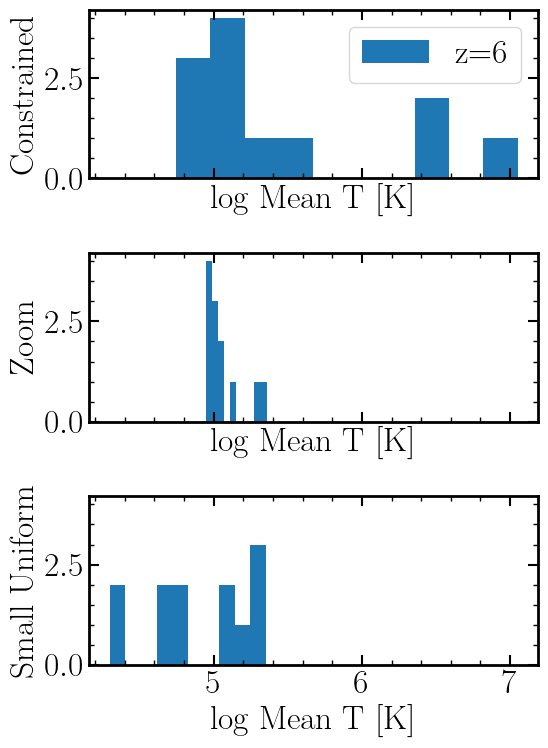

In [7]:
i = 0
fig,axs = plt.subplots(3,1,figsize=(6,8),sharey=True,sharex=True)

axs[0].hist(Mean_temps_C[:,i],label = f'z={redshifts[i]}')
axs[0].set_ylabel('Constrained')
axs[0].set_xlabel('log Mean T [K]')
axs[0].legend()

axs[1].hist(Mean_temps_Z[:,i],label = f'z={redshifts[i]}')
axs[1].set_ylabel('Zoom')
axs[1].set_xlabel('log Mean T [K]')

axs[2].hist(Mean_temps_L[:,i],label = f'z={redshifts[i]}')
axs[2].set_ylabel('Small Uniform')
axs[2].set_xlabel('log Mean T [K]')

fig.tight_layout()
fig.show()

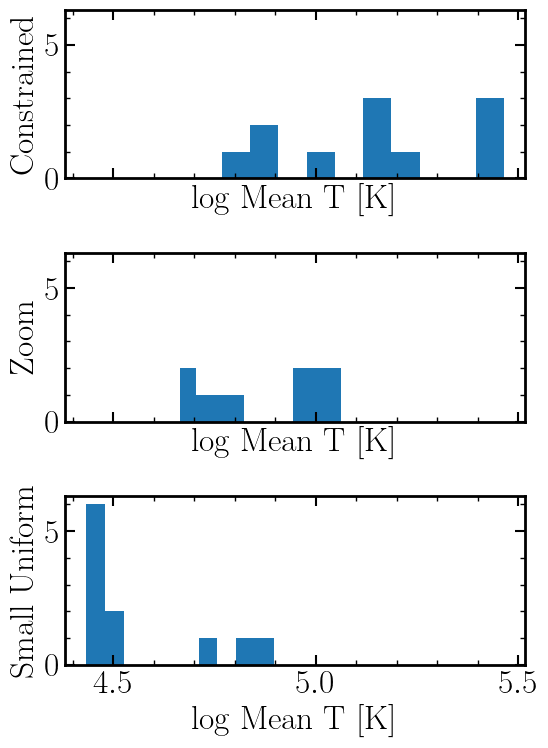

In [8]:
mean_of_means_C = np.mean(Mean_temps_C,axis=0)
mean_of_means_Z = np.mean(Mean_temps_Z,axis=0)
mean_of_means_L = np.mean(Mean_temps_L,axis=0)

fig,axs = plt.subplots(3,1,figsize=(6,8),sharey=True,sharex=True)

axs[0].hist(mean_of_means_C,label = f'z={redshifts[i]}')
axs[0].set_ylabel('Constrained')
axs[0].set_xlabel('log Mean T [K]')

axs[1].hist(mean_of_means_Z,label = f'z={redshifts[i]}')
axs[1].set_ylabel('Zoom')
axs[1].set_xlabel('log Mean T [K]')

axs[2].hist(mean_of_means_L,label = f'z={redshifts[i]}')
axs[2].set_ylabel('Small Uniform')
axs[2].set_xlabel('log Mean T [K]')

fig.tight_layout()
fig.savefig('Plots/Temps/Mean_temps.png')

# Number of cells 1 IQR above the mean vs mean temp plot

In [11]:
data_path = 'output/Temps/'
files = ['Constrained_gas_BH_properties.hdf5','Low_mass_seeds_gas_BH_properties.hdf5','Zooms_gas_BH_properties.hdf5']

h5file = data_path + files[0]
key = keys_C[1]
z=redshifts[1]
box_temp = load_box_data(h5file, key, z, 'gas_temps')

In [12]:
len(box_temp)

348

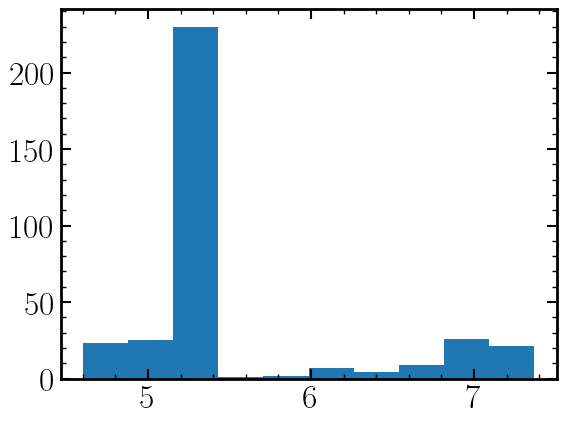

In [13]:
plt.hist(np.log10(box_temp))
plt.show()

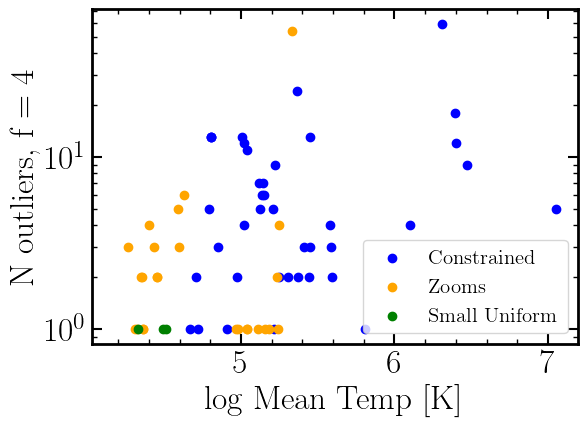

In [16]:
plt.scatter(Mean_temps_C,G1_IQR['C'],color='blue',label='Constrained') 
plt.scatter(Mean_temps_Z,G1_IQR['Z'],color='orange',label = 'Zooms') 
plt.scatter(Mean_temps_L,G1_IQR['L'],color='green',label = 'Small Uniform') 
plt.xlabel('log Mean Temp [K]')
plt.ylabel(f'N outliers, f = {f}') # Outliers: f * IQR above mean temp
plt.yscale('log')
plt.legend(fontsize=15,loc=4)

plt.tight_layout()
plt.savefig(f'Plots/Temps/N_T_f{f}.png')

# Now: want to split the above plot by IC and  color code based on feedback

In [122]:
sim = 'Constrained' # 'Zooms' # 'Small_Uniform' # 

Bondi = [0,1,2,3]
ff = [4,5,6,7]
mod = [8,9,10,11]
AGN = [0,1,4,5,8,9]
noAGN = [2,3,6,7,10,11]

if sim == 'Constrained':
    
    stellar = [1,3,5,7,9,11]
    nostellar = [0,2,4,6,8,10]

elif sim == 'Zooms':

    stellar = [0,2,4,7,8,11]
    nostellar = [1,3,5,6,9,10]

elif sim == 'Small_Uniform':

    stellar = [1,3,5,7,9,11]
    nostellar = [0,2,4,6,8,10]

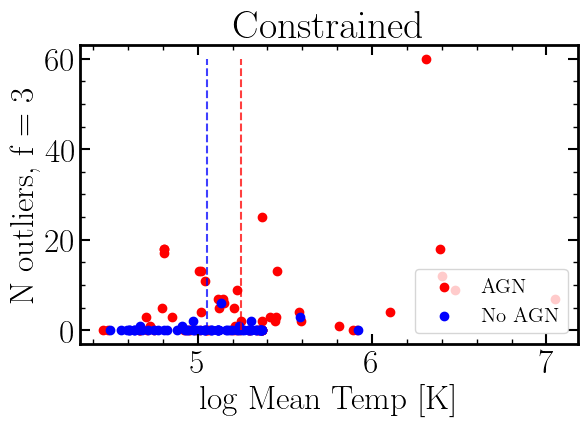

In [42]:
plt.title(f'{sim}')
plt.scatter(Mean_temps['C'][AGN],G1_IQR['C'][AGN],color='red',label='AGN') 
plt.scatter(Mean_temps['C'][noAGN],G1_IQR['C'][noAGN],color='blue',label='No AGN') 
plt.vlines(np.mean(Mean_temps['C'][AGN]),np.min(G1_IQR['C'][AGN]),np.max(G1_IQR['C'][AGN]),
           color='red',ls='--',alpha=0.75)
plt.vlines(np.mean(Mean_temps['C'][noAGN]),np.min(G1_IQR['C'][AGN]),np.max(G1_IQR['C'][AGN]),
           color='blue',ls='--',alpha=0.75)

# plt.hlines(np.mean(G1_IQR['C'][AGN]),np.min(Mean_temps['C'][AGN]),np.max(Mean_temps['C'][AGN]),
#            color='red',ls='--',alpha=0.75)
# plt.hlines(np.mean(G1_IQR['C'][noAGN]),np.min(Mean_temps['C'][AGN]),np.max(Mean_temps['C'][AGN]),
#            color='blue',ls='--',alpha=0.75)

plt.xlabel('log Mean Temp [K]')
plt.ylabel(f'N outliers, f = {f}') # Outliers: f * IQR above mean temp
# plt.yscale('log')
# plt.ylim(-0.1,100)
plt.legend(fontsize=15,loc=4)

plt.tight_layout()
plt.savefig(f'Plots/Temps/N_T_f{f}_{sim}_AGN.png')

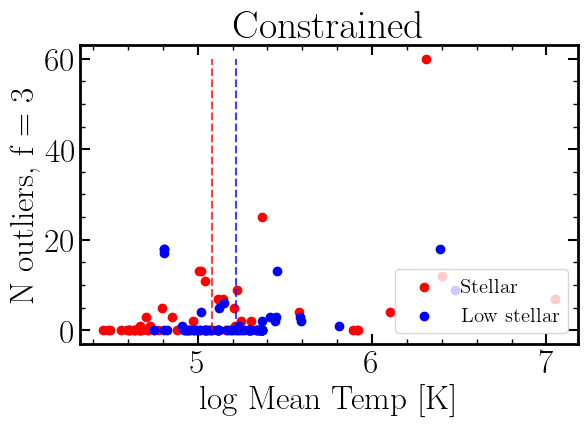

In [43]:
plt.title(f'{sim}')
plt.scatter(Mean_temps['C'][stellar],G1_IQR['C'][stellar],color='red',label='Stellar') 
plt.scatter(Mean_temps['C'][nostellar],G1_IQR['C'][nostellar],color='blue',label='Low stellar') 
plt.vlines(np.mean(Mean_temps['C'][stellar]),np.min(G1_IQR['C'][stellar]),np.max(G1_IQR['C'][stellar]),
           color='red',ls='--',alpha=0.75)
plt.vlines(np.mean(Mean_temps['C'][nostellar]),np.min(G1_IQR['C'][stellar]),np.max(G1_IQR['C'][stellar]),
           color='blue',ls='--',alpha=0.75)
plt.xlabel('log Mean Temp [K]')
plt.ylabel(f'N outliers, f = {f}') # Outliers: f * IQR above mean temp
# plt.yscale('log')
plt.legend(fontsize=15,loc=4)

plt.tight_layout()
plt.savefig(f'Plots/Temps/N_T_f{f}_{sim}_stellar.png')

Now want to plot N star forming vs gas temp

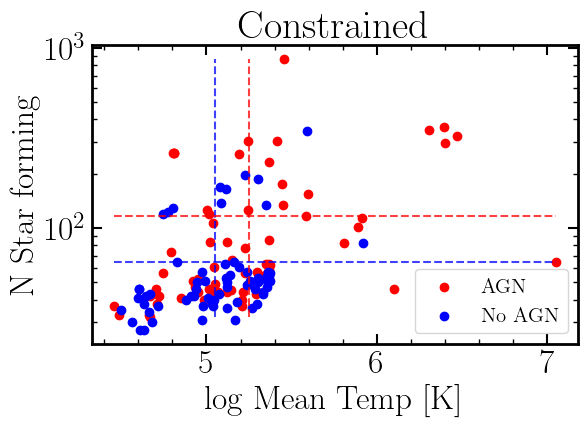

In [46]:
plt.title(f'{sim}')
plt.scatter(Mean_temps['C'][AGN],N_cells['C'][AGN],color='red',label='AGN') 
plt.scatter(Mean_temps['C'][noAGN],N_cells['C'][noAGN],color='blue',label='No AGN') 
plt.vlines(np.mean(Mean_temps['C'][AGN]),np.min(N_cells['C'][AGN]),np.max(N_cells['C'][AGN]),
           color='red',ls='--',alpha=0.75)
plt.vlines(np.mean(Mean_temps['C'][noAGN]),np.min(N_cells['C'][AGN]),np.max(N_cells['C'][AGN]),
           color='blue',ls='--',alpha=0.75)

plt.hlines(np.mean(N_cells['C'][AGN]),np.min(Mean_temps['C'][AGN]),np.max(Mean_temps['C'][AGN]),
           color='red',ls='--',alpha=0.75)
plt.hlines(np.mean(N_cells['C'][noAGN]),np.min(Mean_temps['C'][AGN]),np.max(Mean_temps['C'][AGN]),
           color='blue',ls='--',alpha=0.75)

plt.xlabel('log Mean Temp [K]')
plt.ylabel(f'N Star forming') 
plt.yscale('log')
plt.legend(fontsize=15,loc=4)

plt.tight_layout()
plt.savefig(f'Plots/Temps/N_SF_T_{sim}_AGN.png')

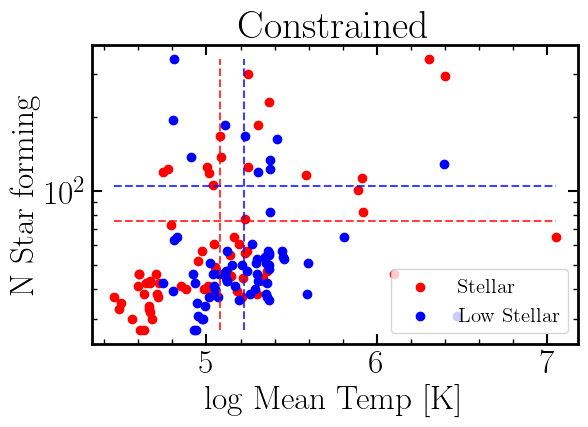

In [44]:
plt.title(f'{sim}')
plt.scatter(Mean_temps['C'][stellar],N_cells['C'][stellar],color='red',label='Stellar') 
plt.scatter(Mean_temps['C'][nostellar],N_cells['C'][noAGN],color='blue',label='Low Stellar') 
plt.vlines(np.mean(Mean_temps['C'][stellar]),np.min(N_cells['C'][stellar]),np.max(N_cells['C'][stellar]),
           color='red',ls='--',alpha=0.75)
plt.vlines(np.mean(Mean_temps['C'][nostellar]),np.min(N_cells['C'][stellar]),np.max(N_cells['C'][stellar]),
           color='blue',ls='--',alpha=0.75)

plt.hlines(np.mean(N_cells['C'][stellar]),np.min(Mean_temps['C'][stellar]),np.max(Mean_temps['C'][stellar]),
           color='red',ls='--',alpha=0.75)
plt.hlines(np.mean(N_cells['C'][nostellar]),np.min(Mean_temps['C'][stellar]),np.max(Mean_temps['C'][stellar]),
           color='blue',ls='--',alpha=0.75)

plt.xlabel('log Mean Temp [K]')
plt.ylabel(f'N Star forming') 
plt.yscale('log')
plt.legend(fontsize=15,loc=4)

plt.tight_layout()
plt.savefig(f'Plots/Temps/N_SF_T_{sim}_stellar.png')

Want to take a look at different redshifts, different accretion models

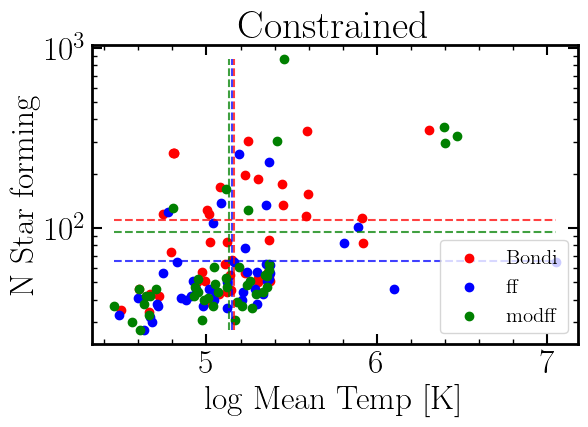

In [50]:
plt.title(f'{sim}')
plt.scatter(Mean_temps['C'][Bondi],N_cells['C'][Bondi],color='red',label='Bondi') 
plt.scatter(Mean_temps['C'][ff],N_cells['C'][ff],color='blue',label='ff') 
plt.scatter(Mean_temps['C'][mod],N_cells['C'][mod],color='green',label='modff') 

plt.vlines(np.mean(Mean_temps['C'][Bondi]),np.min(N_cells['C']),np.max(N_cells['C']),
           color='red',ls='--',alpha=0.75)
plt.vlines(np.mean(Mean_temps['C'][ff]),np.min(N_cells['C']),np.max(N_cells['C']),
           color='blue',ls='--',alpha=0.75)
plt.vlines(np.mean(Mean_temps['C'][mod]),np.min(N_cells['C']),np.max(N_cells['C']),
           color='green',ls='--',alpha=0.75)

plt.hlines(np.mean(N_cells['C'][Bondi]),np.min(Mean_temps['C']),np.max(Mean_temps['C']),
           color='red',ls='--',alpha=0.75)
plt.hlines(np.mean(N_cells['C'][ff]),np.min(Mean_temps['C']),np.max(Mean_temps['C']),
           color='blue',ls='--',alpha=0.75)
plt.hlines(np.mean(N_cells['C'][mod]),np.min(Mean_temps['C']),np.max(Mean_temps['C']),
           color='green',ls='--',alpha=0.75)

plt.xlabel('log Mean Temp [K]')
plt.ylabel(f'N Star forming') 
plt.yscale('log')
plt.legend(fontsize=15,loc=4)

plt.tight_layout()
plt.savefig(f'Plots/Temps/N_SF_T_{sim}_model.png')

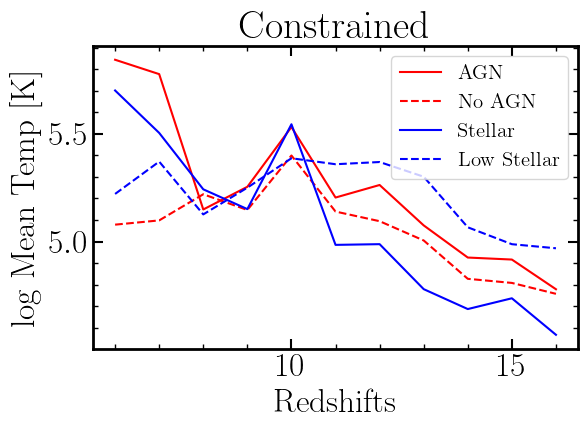

In [114]:
# Plot: Mean temp vs redshift for different feedback strengths, averaged over different accretion models

plt.title(f'{sim}')
plt.plot(redshifts,np.mean(Mean_temps['C'][AGN],axis=0),color='red',label='AGN') 
plt.plot(redshifts,np.mean(Mean_temps['C'][noAGN],axis=0),color='red',label='No AGN',ls='--')

plt.plot(redshifts,np.mean(Mean_temps['C'][stellar],axis=0),color='blue',label='Stellar') 
plt.plot(redshifts,np.mean(Mean_temps['C'][nostellar],axis=0),color='blue',label='Low Stellar',ls='--')

# plt.vlines(np.mean(Mean_temps['C'][AGN]),np.min(N_cells['C'][AGN]),np.max(N_cells['C'][AGN]),
#            color='red',ls='--',alpha=0.75)
# plt.vlines(np.mean(Mean_temps['C'][noAGN]),np.min(N_cells['C'][AGN]),np.max(N_cells['C'][AGN]),
#            color='blue',ls='--',alpha=0.75)

# plt.hlines(np.mean(N_cells['C'][AGN]),np.min(Mean_temps['C'][AGN]),np.max(Mean_temps['C'][AGN]),
#            color='red',ls='--',alpha=0.75)
# plt.hlines(np.mean(N_cells['C'][noAGN]),np.min(Mean_temps['C'][AGN]),np.max(Mean_temps['C'][AGN]),
#            color='blue',ls='--',alpha=0.75)

plt.xlabel('Redshifts')
plt.ylabel(f'log Mean Temp [K]') 
# plt.yscale('log')
plt.legend(fontsize=15,loc=1)

plt.tight_layout()
plt.savefig(f'Plots/Temps/T_z_{sim}.png')

Want to make the above plot but with densities instead of temperatures on the y axis, and for gas density within radius d for ff and modff

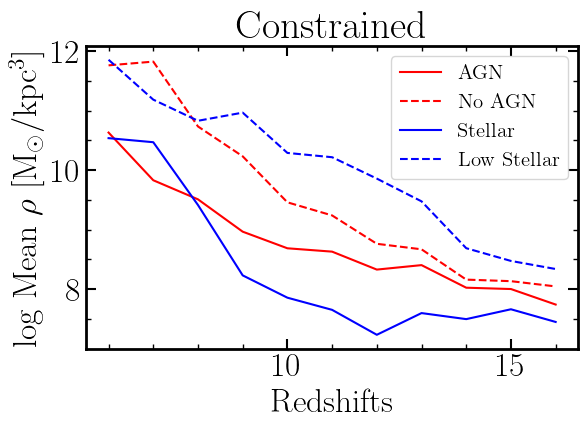

In [115]:
# Plot: Mean temp vs redshift for different feedback strengths, averaged over different accretion models

plt.title(f'{sim}')
plt.plot(redshifts,np.mean(BH_rho['C'][AGN],axis=0),color='red',label='AGN') 
plt.plot(redshifts,np.mean(BH_rho['C'][noAGN],axis=0),color='red',label='No AGN',ls='--')

plt.plot(redshifts,np.mean(BH_rho['C'][stellar],axis=0),color='blue',label='Stellar') 
plt.plot(redshifts,np.mean(BH_rho['C'][nostellar],axis=0),color='blue',label='Low Stellar',ls='--')

plt.xlabel('Redshifts')
plt.ylabel(r'log Mean $\rho$ [$\rm M_\odot/kpc^3$]') 
# plt.yscale('log')
plt.legend(fontsize=15,loc=1)

plt.tight_layout()
plt.savefig(f'Plots/Temps/BH_Rho_z_{sim}.png')

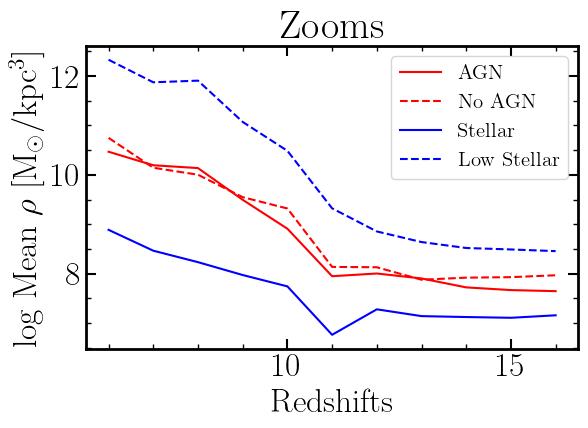

In [117]:
# Plot: Mean temp vs redshift for different feedback strengths, averaged over different accretion models

plt.title(f'{sim}')
plt.plot(redshifts,np.mean(BH_rho['Z'][AGN],axis=0),color='red',label='AGN') 
plt.plot(redshifts,np.mean(BH_rho['Z'][noAGN],axis=0),color='red',label='No AGN',ls='--')

plt.plot(redshifts,np.mean(BH_rho['Z'][stellar],axis=0),color='blue',label='Stellar') 
plt.plot(redshifts,np.mean(BH_rho['Z'][nostellar],axis=0),color='blue',label='Low Stellar',ls='--')

plt.xlabel('Redshifts')
plt.ylabel(r'log Mean $\rho$ [$\rm M_\odot/kpc^3$]') 
# plt.yscale('log')
plt.legend(fontsize=15,loc=1)

plt.tight_layout()
plt.savefig(f'Plots/Temps/BH_Rho_z_{sim}.png')

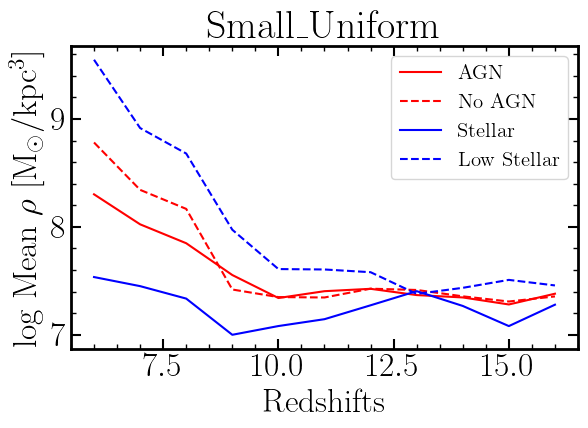

In [119]:
# Plot: Mean temp vs redshift for different feedback strengths, averaged over different accretion models

plt.title(f'{sim}')
plt.plot(redshifts,np.mean(BH_rho['L'][AGN],axis=0),color='red',label='AGN') 
plt.plot(redshifts,np.mean(BH_rho['L'][noAGN],axis=0),color='red',label='No AGN',ls='--')

plt.plot(redshifts,np.mean(BH_rho['L'][stellar],axis=0),color='blue',label='Stellar') 
plt.plot(redshifts,np.mean(BH_rho['L'][nostellar],axis=0),color='blue',label='Low Stellar',ls='--')

plt.xlabel('Redshifts')
plt.ylabel(r'log Mean $\rho$ [$\rm M_\odot/kpc^3$]') 
# plt.yscale('log')
plt.legend(fontsize=15,loc=1)

plt.tight_layout()
plt.savefig(f'Plots/Temps/BH_Rho_z_{sim}.png')

# Rho in d:

In [5]:
sim = 'Constrained' # 'Zooms' # 'Small_Uniform' # 

Bondi = [0,1,2,3]
ff = [4,5,6,7]
mod = [8,9,10,11]
AGN = [0,1,4,5,8,9]
noAGN = [2,3,6,7,10,11]

if sim == 'Constrained':
    
    stellar = [1,3,5,7,9,11]
    nostellar = [0,2,4,6,8,10]

elif sim == 'Zooms':

    stellar = [0,2,4,7,8,11]
    nostellar = [1,3,5,6,9,10]

elif sim == 'Small_Uniform':

    stellar = [1,3,5,7,9,11]
    nostellar = [0,2,4,6,8,10]

In [14]:
means_C_AGN = []
means_C_noAGN = []
means_C_stellar = []
means_C_nostellar = []

for i in range(Rho_in_d['C'][AGN].shape[1]):
    
    mean_AGN = np.mean(Rho_in_d['C'][AGN][:,i][~np.isinf(Rho_in_d['C'][AGN][:,i])],axis = 0) # Still need to figure out why there's inf
    mean_noAGN = np.mean(Rho_in_d['C'][noAGN][:,i][~np.isinf(Rho_in_d['C'][noAGN][:,i])],axis = 0)
    mean_stellar = np.mean(Rho_in_d['C'][stellar][:,i][~np.isinf(Rho_in_d['C'][stellar][:,i])],axis = 0)
    mean_nostellar = np.mean(Rho_in_d['C'][nostellar][:,i][~np.isinf(Rho_in_d['C'][nostellar][:,i])],axis = 0)
    
    means_C_AGN.append(mean_AGN)
    means_C_noAGN.append(mean_noAGN)
    means_C_stellar.append(mean_stellar)
    means_C_nostellar.append(mean_nostellar)


In [ ]:
# Plot: Mean temp vs redshift for different feedback strengths, averaged over different accretion models

plt.title(f'{sim}')
plt.plot(redshifts,means_C_AGN,color='red',label='AGN') 
plt.plot(redshifts,means_C_noAGN,color='red',label='No AGN',ls='--')

plt.plot(redshifts,means_C_stellar,color='blue',label='Stellar') 
plt.plot(redshifts,means_C_nostellar,color='blue',label='Low Stellar',ls='--')

plt.xlabel('Redshifts')
plt.ylabel(r'log Mean $\rho$ in d [$\rm M_\odot/kpc^3$]') 
plt.legend(fontsize=15,loc=1)

plt.tight_layout()
plt.savefig(f'Plots/Temps/BH_Rho_in_d_z_{sim}.png')

# Rho vs temp

Want to make plots of mean rho vs mean temps:

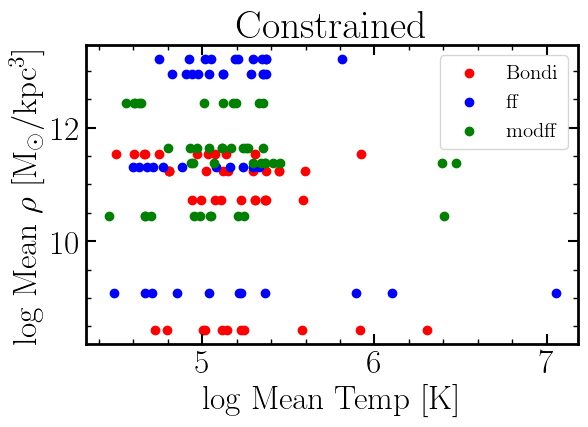

In [34]:
plt.title(f'{sim}')
plt.scatter(Mean_temps['C'][Bondi],BH_rho['C'][Bondi],color='red',label='Bondi') 
plt.scatter(Mean_temps['C'][ff],BH_rho['C'][ff],color='blue',label='ff') 
plt.scatter(Mean_temps['C'][mod],BH_rho['C'][mod],color='green',label='modff') 

plt.xlabel('log Mean Temp [K]')
plt.ylabel(r'log Mean $\rho$ [$\rm M_\odot/kpc^3$]') 
# plt.yscale('log')
plt.legend(fontsize=15)

plt.tight_layout()
plt.savefig(f'Plots/Temps/BH_rho_T_{sim}_model.png')

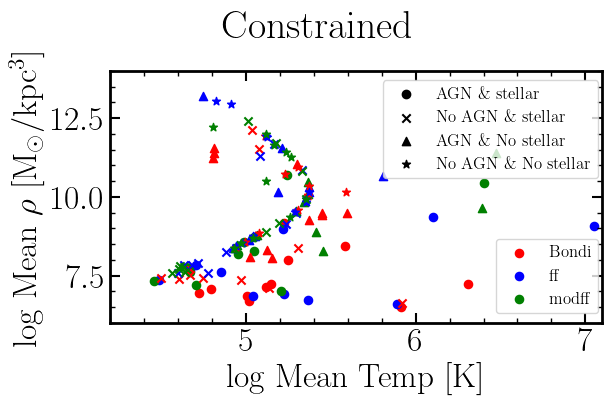

In [135]:
fig, ax = plt.subplots()
fig.suptitle(f'{sim}',y=0.88)

line1 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(AGN) & set(Bondi))],BH_rho['C'][list(set(stellar) & set(AGN) & set(Bondi))],color='red',label='Bondi',s=35) 
line2 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(AGN) & set(ff))],BH_rho['C'][list(set(stellar) & set(AGN) & set(ff))],color='blue',label='ff',s=35) 
line3 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(AGN) & set(mod))],BH_rho['C'][list(set(stellar) & set(AGN) & set(mod))],color='green',label='modff',s=35) 

line4 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(noAGN) & set(Bondi))],BH_rho['C'][list(set(stellar) & set(noAGN) & set(Bondi))],color='red',s=35,marker = 'x') 
line5 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(noAGN) & set(ff))],BH_rho['C'][list(set(stellar) & set(noAGN) & set(ff))],color='blue',s=35,marker = 'x') 
line6 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(noAGN) & set(mod))],BH_rho['C'][list(set(stellar) & set(noAGN) & set(mod))],color='green',s=35,marker = 'x') 

line7 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(AGN) & set(Bondi))],BH_rho['C'][list(set(nostellar) & set(AGN) & set(Bondi))],color='red',s=35,marker = '^') 
line8 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(AGN) & set(ff))],BH_rho['C'][list(set(nostellar) & set(AGN) & set(ff))],color='blue',s=35,marker = '^') 
line9 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(AGN) & set(mod))],BH_rho['C'][list(set(nostellar) & set(AGN) & set(mod))],color='green',s=35,marker = '^') 

line10 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(noAGN) & set(Bondi))],BH_rho['C'][list(set(nostellar) & set(noAGN) & set(Bondi))],color='red',s=35,marker = '*') 
line11 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(noAGN) & set(ff))],BH_rho['C'][list(set(nostellar) & set(noAGN) & set(ff))],color='blue',s=35,marker = '*') 
line12 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(noAGN) & set(mod))],BH_rho['C'][list(set(nostellar) & set(noAGN) & set(mod))],color='green',s=35,marker = '*') 

line13 = ax.scatter(0,0,label = r'AGN \& stellar',color='k')
line14 = ax.scatter(0,0,label = r'No AGN \& stellar',marker = 'x',color='k')
line15 = ax.scatter(0,0,label = r'AGN \& No stellar',marker = '^',color='k')
line16 = ax.scatter(0,0,label = r'No AGN \& No stellar',marker = '*',color='k')

# plt.scatter(Mean_temps['C'][Bondi],BH_rho['C'][Bondi],color='red',label='Bondi') 
# plt.scatter(Mean_temps['C'][ff],BH_rho['C'][ff],color='blue',label='ff') 
# plt.scatter(Mean_temps['C'][mod],BH_rho['C'][mod],color='green',label='modff') 

ax.set_xlabel('log Mean Temp [K]')
ax.set_ylabel(r'log Mean $\rho$ [$\rm M_\odot/kpc^3$]') 

fig.legend(
    handles=[line1, line2, line3],
    labels=['Bondi', 'ff', 'modff'],
    bbox_to_anchor=(0.95, 0.42),
    fontsize=12
)

fig.legend(
    handles=[line13, line14, line15, line16],
    labels=[
        r'AGN \& stellar',
        r'No AGN \& stellar',
        r'AGN \& No stellar',
        r'No AGN \& No stellar'
    ],
    bbox_to_anchor=(0.95, 0.75),
    fontsize=12
)

ax.set_xlim(4.2,7.1)
ax.set_ylim(6,14)

fig.tight_layout()
fig.savefig(f'Plots/Temps/EOS.png')

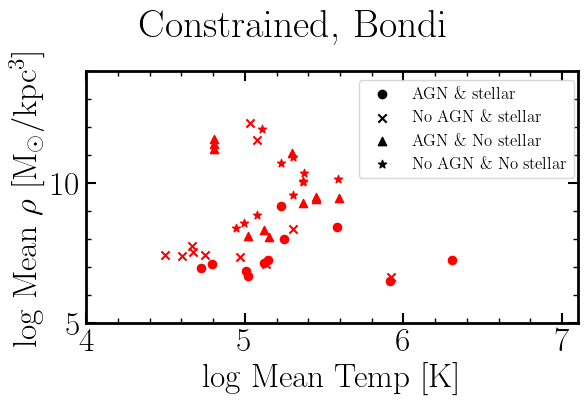

In [130]:
fig, ax = plt.subplots()
fig.suptitle(f'{sim}, Bondi',y=0.88)

line1 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(AGN) & set(Bondi))],BH_rho['C'][list(set(stellar) & set(AGN) & set(Bondi))],color='red',label='Bondi',s=35) 
# line2 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(AGN) & set(ff))],BH_rho['C'][list(set(stellar) & set(AGN) & set(ff))],color='blue',label='ff',s=35) 
# line3 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(AGN) & set(mod))],BH_rho['C'][list(set(stellar) & set(AGN) & set(mod))],color='green',label='modff',s=35) 

line4 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(noAGN) & set(Bondi))],BH_rho['C'][list(set(stellar) & set(noAGN) & set(Bondi))],color='red',s=35,marker = 'x') 
# line5 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(noAGN) & set(ff))],BH_rho['C'][list(set(stellar) & set(noAGN) & set(ff))],color='blue',s=35,marker = 'x') 
# line6 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(noAGN) & set(mod))],BH_rho['C'][list(set(stellar) & set(noAGN) & set(mod))],color='green',s=35,marker = 'x') 

line7 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(AGN) & set(Bondi))],BH_rho['C'][list(set(nostellar) & set(AGN) & set(Bondi))],color='red',s=35,marker = '^') 
# line8 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(AGN) & set(ff))],BH_rho['C'][list(set(nostellar) & set(AGN) & set(ff))],color='blue',s=35,marker = '^') 
# line9 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(AGN) & set(mod))],BH_rho['C'][list(set(nostellar) & set(AGN) & set(mod))],color='green',s=35,marker = '^') 

line10 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(noAGN) & set(Bondi))],BH_rho['C'][list(set(nostellar) & set(noAGN) & set(Bondi))],color='red',s=35,marker = '*') 
# line11 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(noAGN) & set(ff))],BH_rho['C'][list(set(nostellar) & set(noAGN) & set(ff))],color='blue',s=35,marker = '*') 
# line12 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(noAGN) & set(mod))],BH_rho['C'][list(set(nostellar) & set(noAGN) & set(mod))],color='green',s=35,marker = '*') 

line13 = ax.scatter(0,0,label = r'AGN \& stellar',color='k')
line14 = ax.scatter(0,0,label = r'No AGN \& stellar',marker = 'x',color='k')
line15 = ax.scatter(0,0,label = r'AGN \& No stellar',marker = '^',color='k')
line16 = ax.scatter(0,0,label = r'No AGN \& No stellar',marker = '*',color='k')

# plt.scatter(Mean_temps['C'][Bondi],BH_rho['C'][Bondi],color='red',label='Bondi') 
# plt.scatter(Mean_temps['C'][ff],BH_rho['C'][ff],color='blue',label='ff') 
# plt.scatter(Mean_temps['C'][mod],BH_rho['C'][mod],color='green',label='modff') 

ax.set_xlabel('log Mean Temp [K]')
ax.set_ylabel(r'log Mean $\rho$ [$\rm M_\odot/kpc^3$]') 

# fig.legend(
#     handles=[line1, line2, line3],
#     labels=['Bondi', 'ff', 'modff'],
#     bbox_to_anchor=(0.95, 0.42),
#     fontsize=12
# )

fig.legend(
    handles=[line13, line14, line15, line16],
    labels=[
        r'AGN \& stellar',
        r'No AGN \& stellar',
        r'AGN \& No stellar',
        r'No AGN \& No stellar'
    ],
    bbox_to_anchor=(0.95, 0.75),
    fontsize=12
)

ax.set_xlim(4,7.1)
ax.set_ylim(5,14)

fig.tight_layout()
fig.savefig(f'Plots/Temps/Con_Bondi_rho_T.png')

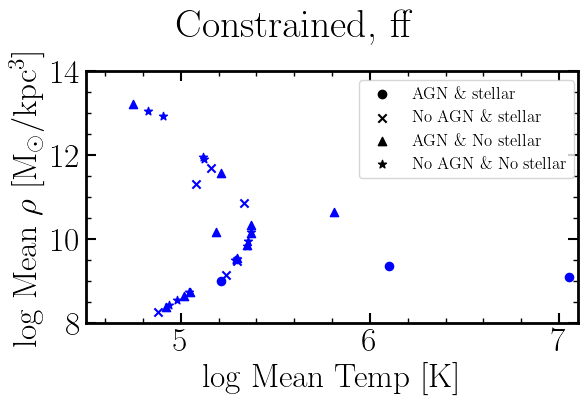

In [131]:
fig, ax = plt.subplots()
fig.suptitle(f'{sim}, ff',y=0.88)

# line1 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(AGN) & set(Bondi))],BH_rho['C'][list(set(stellar) & set(AGN) & set(Bondi))],color='red',label='Bondi',s=35) 
line2 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(AGN) & set(ff))],BH_rho['C'][list(set(stellar) & set(AGN) & set(ff))],color='blue',label='ff',s=35) 
# line3 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(AGN) & set(mod))],BH_rho['C'][list(set(stellar) & set(AGN) & set(mod))],color='green',label='modff',s=35) 

# line4 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(noAGN) & set(Bondi))],BH_rho['C'][list(set(stellar) & set(noAGN) & set(Bondi))],color='red',s=35,marker = 'x') 
line5 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(noAGN) & set(ff))],BH_rho['C'][list(set(stellar) & set(noAGN) & set(ff))],color='blue',s=35,marker = 'x') 
# line6 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(noAGN) & set(mod))],BH_rho['C'][list(set(stellar) & set(noAGN) & set(mod))],color='green',s=35,marker = 'x') 

# line7 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(AGN) & set(Bondi))],BH_rho['C'][list(set(nostellar) & set(AGN) & set(Bondi))],color='red',s=35,marker = '^') 
line8 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(AGN) & set(ff))],BH_rho['C'][list(set(nostellar) & set(AGN) & set(ff))],color='blue',s=35,marker = '^') 
# line9 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(AGN) & set(mod))],BH_rho['C'][list(set(nostellar) & set(AGN) & set(mod))],color='green',s=35,marker = '^') 

# line10 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(noAGN) & set(Bondi))],BH_rho['C'][list(set(nostellar) & set(noAGN) & set(Bondi))],color='red',s=35,marker = '*') 
line11 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(noAGN) & set(ff))],BH_rho['C'][list(set(nostellar) & set(noAGN) & set(ff))],color='blue',s=35,marker = '*') 
# line12 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(noAGN) & set(mod))],BH_rho['C'][list(set(nostellar) & set(noAGN) & set(mod))],color='green',s=35,marker = '*') 

line13 = ax.scatter(0,0,label = r'AGN \& stellar',color='k')
line14 = ax.scatter(0,0,label = r'No AGN \& stellar',marker = 'x',color='k')
line15 = ax.scatter(0,0,label = r'AGN \& No stellar',marker = '^',color='k')
line16 = ax.scatter(0,0,label = r'No AGN \& No stellar',marker = '*',color='k')

# plt.scatter(Mean_temps['C'][Bondi],BH_rho['C'][Bondi],color='red',label='Bondi') 
# plt.scatter(Mean_temps['C'][ff],BH_rho['C'][ff],color='blue',label='ff') 
# plt.scatter(Mean_temps['C'][mod],BH_rho['C'][mod],color='green',label='modff') 

ax.set_xlabel('log Mean Temp [K]')
ax.set_ylabel(r'log Mean $\rho$ [$\rm M_\odot/kpc^3$]') 

# fig.legend(
#     handles=[line1, line2, line3],
#     labels=['Bondi', 'ff', 'modff'],
#     bbox_to_anchor=(0.95, 0.42),
#     fontsize=12
# )

fig.legend(
    handles=[line13, line14, line15, line16],
    labels=[
        r'AGN \& stellar',
        r'No AGN \& stellar',
        r'AGN \& No stellar',
        r'No AGN \& No stellar'
    ],
    bbox_to_anchor=(0.95, 0.75),
    fontsize=12
)

ax.set_xlim(4.5,7.1)
ax.set_ylim(8,14)

fig.tight_layout()
fig.savefig(f'Plots/Temps/Con_ff_rho_T.png')

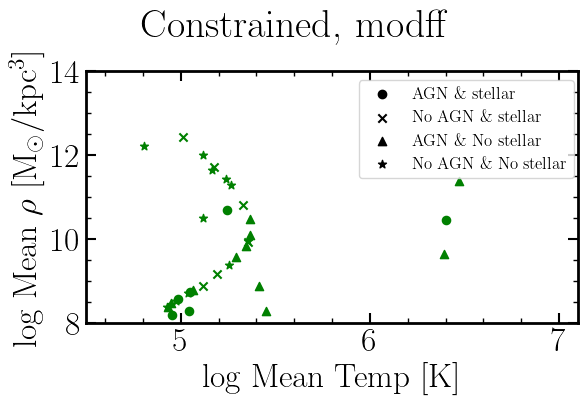

In [132]:
fig, ax = plt.subplots()
fig.suptitle(f'{sim}, modff',y=0.88)

# line1 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(AGN) & set(Bondi))],BH_rho['C'][list(set(stellar) & set(AGN) & set(Bondi))],color='red',label='Bondi',s=35) 
# line2 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(AGN) & set(ff))],BH_rho['C'][list(set(stellar) & set(AGN) & set(ff))],color='blue',label='ff',s=35) 
line3 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(AGN) & set(mod))],BH_rho['C'][list(set(stellar) & set(AGN) & set(mod))],color='green',label='modff',s=35) 

# line4 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(noAGN) & set(Bondi))],BH_rho['C'][list(set(stellar) & set(noAGN) & set(Bondi))],color='red',s=35,marker = 'x') 
# line5 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(noAGN) & set(ff))],BH_rho['C'][list(set(stellar) & set(noAGN) & set(ff))],color='blue',s=35,marker = 'x') 
line6 = ax.scatter(Mean_temps['C'][list(set(stellar) & set(noAGN) & set(mod))],BH_rho['C'][list(set(stellar) & set(noAGN) & set(mod))],color='green',s=35,marker = 'x') 

# line7 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(AGN) & set(Bondi))],BH_rho['C'][list(set(nostellar) & set(AGN) & set(Bondi))],color='red',s=35,marker = '^') 
# line8 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(AGN) & set(ff))],BH_rho['C'][list(set(nostellar) & set(AGN) & set(ff))],color='blue',s=35,marker = '^') 
line9 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(AGN) & set(mod))],BH_rho['C'][list(set(nostellar) & set(AGN) & set(mod))],color='green',s=35,marker = '^') 

# line10 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(noAGN) & set(Bondi))],BH_rho['C'][list(set(nostellar) & set(noAGN) & set(Bondi))],color='red',s=35,marker = '*') 
# line11 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(noAGN) & set(ff))],BH_rho['C'][list(set(nostellar) & set(noAGN) & set(ff))],color='blue',s=35,marker = '*') 
line12 = ax.scatter(Mean_temps['C'][list(set(nostellar) & set(noAGN) & set(mod))],BH_rho['C'][list(set(nostellar) & set(noAGN) & set(mod))],color='green',s=35,marker = '*') 

line13 = ax.scatter(0,0,label = r'AGN \& stellar',color='k')
line14 = ax.scatter(0,0,label = r'No AGN \& stellar',marker = 'x',color='k')
line15 = ax.scatter(0,0,label = r'AGN \& No stellar',marker = '^',color='k')
line16 = ax.scatter(0,0,label = r'No AGN \& No stellar',marker = '*',color='k')

# plt.scatter(Mean_temps['C'][Bondi],BH_rho['C'][Bondi],color='red',label='Bondi') 
# plt.scatter(Mean_temps['C'][ff],BH_rho['C'][ff],color='blue',label='ff') 
# plt.scatter(Mean_temps['C'][mod],BH_rho['C'][mod],color='green',label='modff') 

ax.set_xlabel('log Mean Temp [K]')
ax.set_ylabel(r'log Mean $\rho$ [$\rm M_\odot/kpc^3$]') 

# fig.legend(
#     handles=[line1, line2, line3],
#     labels=['Bondi', 'ff', 'modff'],
#     bbox_to_anchor=(0.95, 0.42),
#     fontsize=12
# )

fig.legend(
    handles=[line13, line14, line15, line16],
    labels=[
        r'AGN \& stellar',
        r'No AGN \& stellar',
        r'AGN \& No stellar',
        r'No AGN \& No stellar'
    ],
    bbox_to_anchor=(0.95, 0.75),
    fontsize=12
)

ax.set_xlim(4.5,7.1)
ax.set_ylim(8,14)

fig.tight_layout()
fig.savefig(f'Plots/Temps/Con_modff_rho_T.png')

# T vs z

Also want to make the above plot for Zooms and Small Uniform boxes

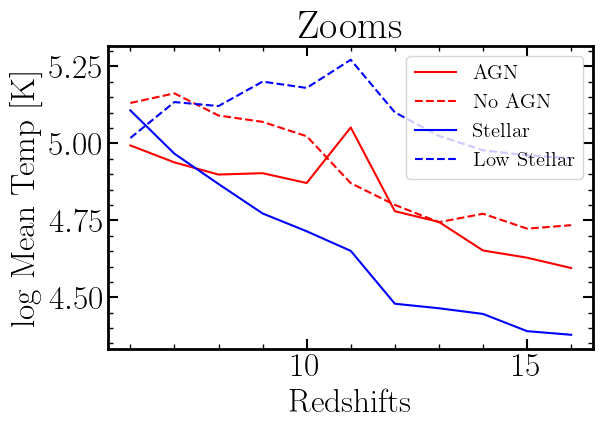

In [23]:
# Plot: Mean temp vs redshift for different feedback strengths, averaged over different accretion models
sim = 'Zooms'
plt.title(f'{sim}')
plt.plot(redshifts,np.mean(Mean_temps['Z'][AGN],axis=0),color='red',label='AGN') 
plt.plot(redshifts,np.mean(Mean_temps['Z'][noAGN],axis=0),color='red',label='No AGN',ls='--')

plt.plot(redshifts,np.mean(Mean_temps['Z'][stellar],axis=0),color='blue',label='Stellar') 
plt.plot(redshifts,np.mean(Mean_temps['Z'][nostellar],axis=0),color='blue',label='Low Stellar',ls='--')

plt.xlabel('Redshifts')
plt.ylabel(f'log Mean Temp [K]') 
# plt.yscale('log')
plt.legend(fontsize=15,loc=1)

plt.tight_layout()
plt.savefig(f'Plots/Temps/T_z_{sim}.png')

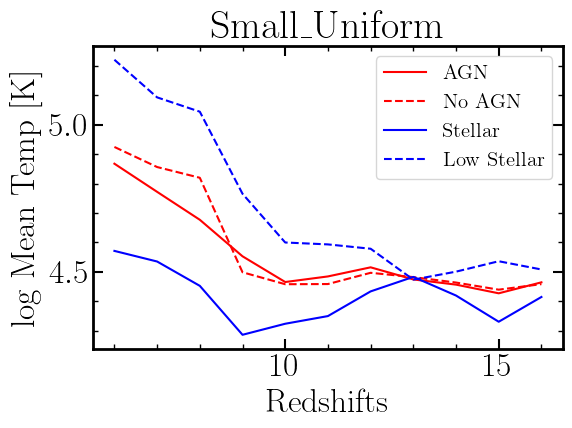

In [25]:
# Plot: Mean temp vs redshift for different feedback strengths, averaged over different accretion models
sim = 'Small_Uniform'
plt.title(f'{sim}')
plt.plot(redshifts,np.mean(Mean_temps['L'][AGN],axis=0),color='red',label='AGN') 
plt.plot(redshifts,np.mean(Mean_temps['L'][noAGN],axis=0),color='red',label='No AGN',ls='--')

plt.plot(redshifts,np.mean(Mean_temps['L'][stellar],axis=0),color='blue',label='Stellar') 
plt.plot(redshifts,np.mean(Mean_temps['L'][nostellar],axis=0),color='blue',label='Low Stellar',ls='--')

plt.xlabel('Redshifts')
plt.ylabel(f'log Mean Temp [K]') 
# plt.yscale('log')
plt.legend(fontsize=15,loc=1)

plt.tight_layout()
plt.savefig(f'Plots/Temps/T_z_{sim}.png')

# Different accretion models?

Repeating above plot, but differentiating different accretion models

In [ ]:
# Plot: Mean temp vs redshift for different feedback strengths, averaged over different accretion models

plt.title(f'{sim}')
plt.plot(redshifts,np.mean(Mean_temps['C'][AGN],axis=0),color='red',label='AGN') 
plt.plot(redshifts,np.mean(Mean_temps['C'][noAGN],axis=0),color='red',label='No AGN',ls='--')

plt.plot(redshifts,np.mean(Mean_temps['C'][stellar],axis=0),color='blue',label='Stellar') 
plt.plot(redshifts,np.mean(Mean_temps['C'][nostellar],axis=0),color='blue',label='Low Stellar',ls='--')

plt.xlabel('Redshifts')
plt.ylabel(f'log Mean Temp [K]') 
# plt.yscale('log')
plt.legend(fontsize=15,loc=1)

plt.tight_layout()
plt.savefig(f'Plots/Temps/T_z_{sim}.png')

# Want to load in the SFRs of the gas cells to see if a highly star forming gas cell could be causing the high temps via the EOS

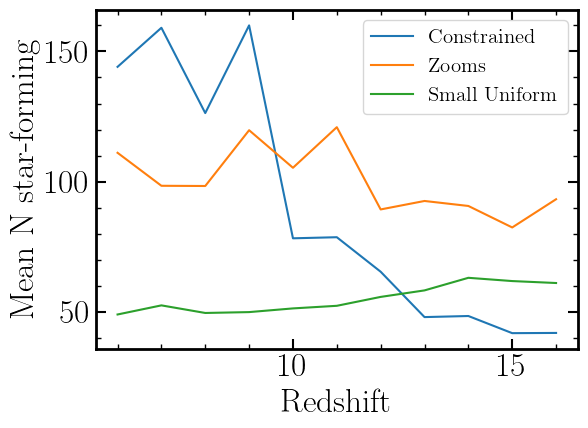

In [10]:
plt.plot(redshifts,np.mean(N_cells['C'],axis=0),label = 'Constrained')
plt.plot(redshifts,np.mean(N_cells['Z'],axis=0),label = 'Zooms')
plt.plot(redshifts,np.mean(N_cells['L'],axis=0),label = 'Small Uniform')
plt.legend(fontsize=15)
plt.xlabel('Redshift')
plt.ylabel('Mean N star-forming')
plt.tight_layout()
# plt.yscale('log')
plt.savefig('Plots/Temps/N_SFR.png')

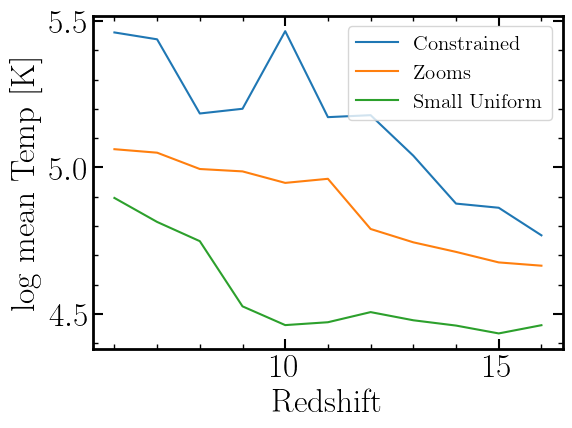

In [5]:
plt.plot(redshifts,np.mean(Mean_temps['C'],axis=0),label = 'Constrained')
plt.plot(redshifts,np.mean(Mean_temps['Z'],axis=0),label = 'Zooms')
plt.plot(redshifts,np.mean(Mean_temps['L'],axis=0),label = 'Small Uniform')
plt.legend(fontsize=15)
plt.xlabel('Redshift')
plt.ylabel('log mean Temp [K]')
plt.tight_layout()
# plt.yscale('log')
plt.savefig('Plots/Temps/T_models.png')